# 1- exploration et netoyage du dataset

In [10]:
import json

annotation_path = "D:/Users/HP/Bureau/vehicle-damage-detection/data/raw/CarDD_release/CarDD_COCO/annotations/instances_train2017.json"

with open(annotation_path, "r", encoding="utf-8") as f:
    coco_data = json.load(f)


In [ ]:
#liste des classes
categories = coco_data["categories"]

for cat in categories:
    print(f"ID: {cat['id']} | Nom: {cat['name']}")


ID: 1 | Nom: dent
ID: 2 | Nom: scratch
ID: 3 | Nom: crack
ID: 4 | Nom: glass shatter
ID: 5 | Nom: lamp broken
ID: 6 | Nom: tire flat


In [ ]:
# Nombre d'element par classe
rom collections import Counter

annotations = coco_data["annotations"]

class_counts = Counter()

for ann in annotations:
    class_counts[ann["category_id"]] += 1

for cat in coco_data["categories"]:
    print(f"{cat['name']} : {class_counts[cat['id']]}")


dent : 1806
scratch : 2560
crack : 651
glass shatter : 475
lamp broken : 494
tire flat : 225


In [ ]:
image_ids_with_ann = set(ann["image_id"] for ann in annotations)
all_image_ids = set(img["id"] for img in coco_data["images"])

images_without_ann = all_image_ids - image_ids_with_ann

print("Nombre total d'images :", len(all_image_ids))
print("Images sans annotation :", len(images_without_ann))


Nombre total d'images : 2816
Images sans annotation : 0


In [ ]:
invalid_boxes = []

for ann in annotations:
    x, y, w, h = ann["bbox"]
    if w <= 0 or h <= 0:
        invalid_boxes.append(ann)

print("Nombre de bounding boxes invalides :", len(invalid_boxes))


Nombre de bounding boxes invalides : 0


In [ ]:
small_boxes = []

for ann in annotations:
    _, _, w, h = ann["bbox"]
    if w < 5 or h < 5:   # seuil simple en pixels
        small_boxes.append(ann)

print("Nombre de bounding boxes très petites :", len(small_boxes))


Nombre de bounding boxes très petites : 0


In [ ]:
valid_image_ids = image_ids_with_ann
print("Nombre d'images valides :", len(valid_image_ids))


Nombre d'images valides : 2816


In [ ]:
categories = coco_data["categories"]

class_id_to_index = {
    cat["id"]: idx for idx, cat in enumerate(categories)
}

index_to_class = {
    idx: cat["name"] for idx, cat in enumerate(categories)
}

print(class_id_to_index)


{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


In [ ]:
filtered_annotations = [
    ann for ann in annotations
    if ann["image_id"] in valid_image_ids
       and ann["category_id"] in class_id_to_index
]

print("Annotations initiales :", len(annotations))
print("Annotations après filtrage :", len(filtered_annotations))


Annotations initiales : 6211
Annotations après filtrage : 6211


In [ ]:
from collections import defaultdict

image_to_annotations = defaultdict(list)

for ann in filtered_annotations:
    image_to_annotations[ann["image_id"]].append(ann)

print("Nombre d’images avec au moins une annotation :", len(image_to_annotations))


Nombre d’images avec au moins une annotation : 2816


In [ ]:
print("Résumé du dataset CarDD (train)")
print("-------------------------------")
print("Images totales :", len(coco_data["images"]))
print("Images avec dommages :", len(image_to_annotations))
print("Nombre total de dommages :", len(filtered_annotations))
print("Nombre de classes :", len(class_id_to_index))


Résumé du dataset CarDD (train)
-------------------------------
Images totales : 2816
Images avec dommages : 2816
Nombre total de dommages : 6211
Nombre de classes : 6


# 2-vérification des annotations

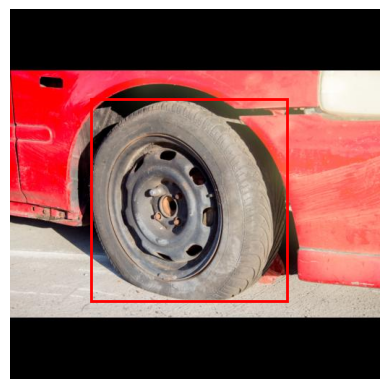

In [ ]:
import json
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# chemins
IMG_DIR = "D:/Users/HP/Bureau/vehicle-damage-detection/data/processed/images_train"
ANN_PATH = "D:/Users/HP/Bureau/vehicle-damage-detection/data/processed/annotations_train.json"

# charger annotations
with open(ANN_PATH, "r", encoding="utf-8") as f:
    coco_p = json.load(f)

# index image -> annotations
from collections import defaultdict
img_to_anns = defaultdict(list)
for ann in coco_p["annotations"]:
    img_to_anns[ann["image_id"]].append(ann)

# choisir une image au hasard
img_info = random.choice(coco_p["images"])
img_path = os.path.join(IMG_DIR, img_info["file_name"])

img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")

# dessiner les bbox
W, H = img.size
for ann in img_to_anns[img_info["id"]]:
    cx, cy, w, h = ann["bbox"]  # normalisées [0,1]
    x = (cx - w/2) * W
    y = (cy - h/2) * H
    rect = plt.Rectangle((x, y), w*W, h*H, fill=False, color="red", linewidth=2)
    plt.gca().add_patch(rect)

plt.show()


# 3- Création du datasets pytorch

## pytorch transform

In [12]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # PIL -> Tensor [0,1]
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset = CarDDDataset(
    images_dir="../data/processed/images_train",
    annotations_path="../data/processed/annotations_train.json",
    transform=transform
)

img, boxes, labels = dataset[0]
print(img.shape, boxes.shape, labels.shape)


torch.Size([3, 512, 512]) torch.Size([2, 4]) torch.Size([2])


## Data loader

In [9]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # PIL -> Tensor [0,1]
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset = CarDDDataset(
    images_dir="../data/processed/images_train",
    annotations_path="../data/processed/annotations_train.json",
    transform=transform
)

img, boxes, labels = dataset[0]
print(img.shape, boxes.shape, labels.shape)


torch.Size([3, 512, 512]) torch.Size([2, 4]) torch.Size([2])
